In [176]:
import re
import os

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

### Setup

In [177]:
lothar = '/home/enno/uni/SS24/thesis/1_RegEx/1_TMP'

R = 10
E = '1E'
M = 2

if os.getcwd() == lothar:
    df = pd.read_csv('/home/enno/uni/SS24/thesis/1_RegEx/0_data/regEx.csv')
    
    clans_file = f'/home/enno/uni/SS24/thesis/1_RegEx/1_TMP/clans_out/{R}R_{M}MM_seq_{E}.clans'
    clstr_file = f'/home/enno/uni/SS24/thesis/1_RegEx/1_TMP/cd_out/{R}R_{M}MM_seq.clstr'
    
    full_fasta_file = f'/home/enno/uni/SS24/thesis/1_RegEx/0_data/fasta/{R}R_{M}MM_seq.fasta'
    cd_out_fasta_file = f'/home/enno/uni/SS24/thesis/1_RegEx/1_TMP/cd_out/{R}R_{M}MM_seq.fasta'
else:
    # TODO
    pass

In [178]:
print(len(df))
df.head()

36455


,id,seq,stretch_ix,stretch_seq,c,npf_x,npf_y,1R_0MM_seq,1R_0MM_ix,1R_0MM_n,...,1R_2MM_n,3R_2MM_seq,3R_2MM_ix,3R_2MM_n,5R_2MM_seq,5R_2MM_ix,5R_2MM_n,10R_2MM_seq,10R_2MM_ix,10R_2MM_n
0,MCD6041253.1,mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...",['rlvyvavaailcsfsttslagaektakragkfvektatragkfv...,-1.0,-567.38850,34.030270,"[['lvyvavaailc', 'vyvavaailcs', 'lagaektakra',...","[[[1, 12], [2, 13], [18, 29], [25, 36], [36, 4...",7,...,37,"[['aailcsfsttslagaektakragkfvektatra', 'sttsla...","[[[7, 40], [14, 47], [18, 51], [25, 58], [36, ...",5,[['sttslagaektakragkfvektatragkfvertatkagkfver...,"[[[14, 69]]]",1,[[]],[[]],0
1,MCD7737945.1,mqgrvffreaaalilaaalsmaglpasaaansgieaaalrteeete...,"[[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, ...",['eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqe...,-1.0,313.18863,-218.576080,[[]],[[]],0,...,58,[[]],[[]],0,[[]],[[]],0,[[]],[[]],0
2,MYF28459.1,merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...",['erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaet...,-1.0,535.79120,-22.468689,"[['ihalrgemhae', 'isgvrervarv', 'varvethlqrt']]","[[[10, 21], [50, 61], [57, 68]]]",3,...,47,"[['ihalrgemhaefasvrqemhagfasirqemhae', 'mhagfa...","[[[10, 43], [28, 61]]]",2,[[]],[[]],0,[[]],[[]],0
3,WP_168920948.1,msdvfltasyadrekvktlgarwnpaekrwyvpsgrdlspfaawlp...,"[[437, 438, 439, 440, 441, 442, 443, 444, 445,...",['aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaq...,41.0,-346.27220,104.598206,"[['aqslvveikha', 'vveikhaasqq', 'lllarhvvpar',...","[[[0, 11], [4, 15], [15, 26], [24, 35], [48, 5...",6,...,82,"[['aqslvveikhaasqqlllarhvvparmaevtae', 'lvveik...","[[[0, 33], [3, 36], [4, 37], [15, 48], [26, 59...",6,[['vveikhaasqqlllarhvvparmaevtaegrqalrtakaqsqa...,"[[[4, 59]]]",1,[[]],[[]],0
4,WP_026306873.1,mllrriarpllsaafiaegidilqnpgpladrlspaldftrrrsqh...,"[[172, 173, 174, 175, 176, 177, 178, 179, 180,...",['slgwrgrraardakdhaealaataaaiaatarergtnlvdtare...,37.0,164.44267,341.078280,"[['ardakdhaeal', 'aealaataaai', 'alaataaaiaa',...","[[[9, 20], [16, 27], [18, 29], [20, 31], [21, ...",15,...,114,"[['lgwrgrraardakdhaealaataaaiaatarer', 'grraar...","[[[1, 34], [5, 38], [9, 42], [12, 45], [16, 49...",15,[[]],[[]],0,[[]],[[]],0


In [179]:
tmp_df = df[(df['5R_1MM_n'] > 0) & (df['c'] == 0)].reset_index(drop=True)
len(tmp_df)

2655

#### Parse Cluster Indices from .clans

In [180]:
def parse_numbers(filename):
    # Extracts the cluster assignment for 5R hits from the .clans file

    clusters = []
    with open(filename, 'r') as file:
       
        for line in file:
            
            if re.match('numbers=', line):
                
                _, num_str = line.split('=')
                numbers = [int(num.strip()) for num in num_str.split(';')[:-1]]

                clusters.append(numbers)
    
    return clusters

In [181]:
clans_numbers = parse_numbers(clans_file)

#### Parse CD-HIT outfile to get Representatives

In [182]:
def parse_cluster_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    clusters = {}
    current_representative = None

    for line in lines:
        if line.startswith('>Cluster'):
            # This line is the start of a new cluster, so the next line will contain the representative sequence
            current_representative = None
        else:
            # This line contains a sequence
            sequence = line.split(', ')[1].split('...')[0].strip()
            if current_representative is None:
                # This is the first sequence in the cluster, so it's the representative sequence
                current_representative = sequence
            clusters[sequence[1:]] = current_representative[1:]

    return clusters

In [183]:
rep_dict = parse_cluster_file(clstr_file)

#### Create DataFrame for Representatives

In [184]:
cd_out_hit_df = pd.DataFrame(columns=['id', 'stretch_x', 'seq_x', 'rep_id'])
ix = 0

with open(cd_out_fasta_file, 'r') as file:

    lines = [line.strip() for line in file.readlines()]
    headers = lines[::2]
    seqs = lines[1::2]
    
    for header_str in headers:

        header = header_str.split('_')
        id, strx, sx = '_'.join(header[:-7])[1:], header[-3], header[-1]
        
        cd_out_hit_df.loc[ix] = [id, strx, sx, header_str[1:]]
        ix += 1

In [185]:
# Assign the cluster number to each sequence
for c, numbers in enumerate(clans_numbers):
    
    cd_out_hit_df.loc[numbers, 'c'] = c

cd_out_hit_df.loc[cd_out_hit_df['c'].isna(), ['c']] = -1  # unassigned = -1

In [186]:
print(len(cd_out_hit_df))
cd_out_hit_df.head()

3507


,id,stretch_x,seq_x,rep_id,c
0,MBQ9252633.1,0,0,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_0,0.0
1,MBQ9252633.1,0,4,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_4,0.0
2,MBQ9252633.1,0,6,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_6,0.0
3,MBQ9252633.1,0,11,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_11,0.0
4,WP_075688569.1,0,0,WP_075688569.1_10R_2MM_seq_stretch_0_seq_0,2.0


In [187]:
# Add x and y coordinates from CLANS to the dataframe
with open(clans_file, 'r') as file:
    data = file.readlines()

data = [line.strip() for line in data]

first_pos = 1
for line in data:
    if line == '<pos>':
        break
    else:
        first_pos += 1

last_pos = first_pos + len(cd_out_hit_df)

pos = [x.split() for x in data[first_pos:last_pos]]

cd_out_hit_df['x'] = [float(x[1]) for x in pos]
cd_out_hit_df['y'] = [float(x[2]) for x in pos]

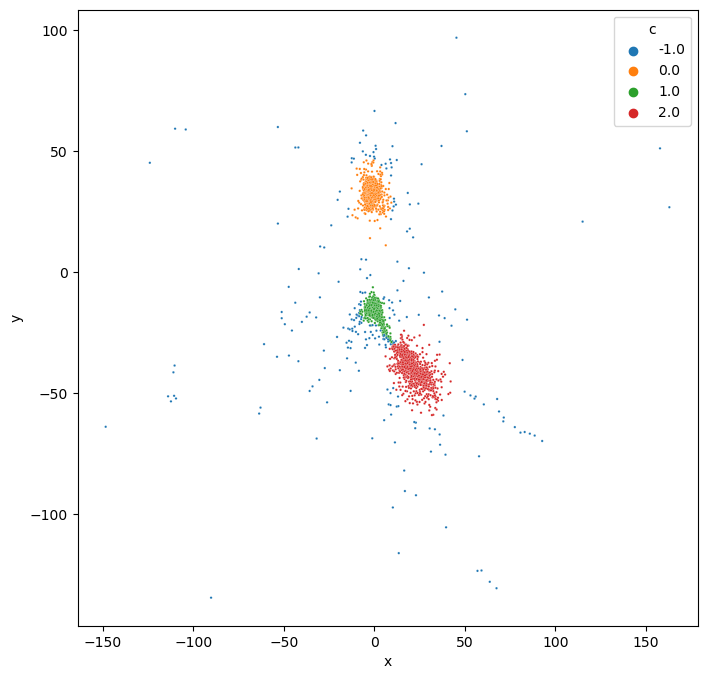

In [188]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=cd_out_hit_df, x='x', y='y', hue='c', palette='tab10', s=3)
plt.show()

#### Create DataFrame for all RegEx Hits

In [189]:
full_hit_df = pd.DataFrame(columns=['id', 'stretch_x', 'seq_x', 'header'])
ix = 0

with open(full_fasta_file, 'r') as file:

    lines = [line.strip() for line in file.readlines()]
    headers = lines[::2]
    seqs = lines[1::2]
    
    for header_str in headers:

        header = header_str.split('_')
        id, strx, sx = '_'.join(header[:-7])[1:], header[-3], header[-1]
        full_hit_df.loc[ix] = [id, strx, sx, header_str[1:]]
        ix += 1

In [190]:
# Assign each hit its representative hit
full_hit_df['rep_id'] = full_hit_df['header'].apply(lambda x: rep_dict[x])

In [191]:
len(np.unique(list(rep_dict.keys()))), len(np.unique(list(rep_dict.values())))

(16880, 3507)

In [192]:
print(len(full_hit_df))
full_hit_df.head()

16880


,id,stretch_x,seq_x,header,rep_id
0,MBQ9252633.1,0,0,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_0,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_0
1,MBQ9252633.1,0,1,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_1,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_0
2,MBQ9252633.1,0,2,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_2,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_0
3,MBQ9252633.1,0,3,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_3,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_0
4,MBQ9252633.1,0,4,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_4,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_4


#### Merge Reprenstative and Full Hit DataFrame

In [193]:
merged_df = full_hit_df.merge(cd_out_hit_df[['rep_id', 'c']], on='rep_id', how='right')

print(len(merged_df))
merged_df.head(5)

16880


,id,stretch_x,seq_x,header,rep_id,c
0,MBQ9252633.1,0,0,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_0,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_0,0.0
1,MBQ9252633.1,0,1,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_1,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_0,0.0
2,MBQ9252633.1,0,2,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_2,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_0,0.0
3,MBQ9252633.1,0,3,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_3,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_0,0.0
4,MBQ9252633.1,0,4,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_4,MBQ9252633.1_10R_2MM_seq_stretch_0_seq_4,0.0


#### Derive Cluster Profile for Original Sequences

In [194]:
cluster_cols = [f'C{ix}' for ix in range(len(clans_numbers))] + ['C-1']
tmp_df[cluster_cols] = 0

In [195]:
for ix in range(len(tmp_df)): 
    print(f'Progress: {ix+1}/{len(tmp_df)}', end='\r')

    current_seq = tmp_df.iloc[ix]
    current_id = current_seq['id']

    tmp_merged_df = merged_df[merged_df['id'] == current_id]

    for cluster in tmp_merged_df['c']:
        tmp_df.loc[ix, f'C{int(cluster)}'] += 1

In [196]:
heights = [0 for _ in range(len(clans_numbers) + 1)]

for i in range(len(tmp_df)):
    current_seq = tmp_df.iloc[i]

    c = 0

    for cx in [f'C{ix}' for ix in range(len(clans_numbers))]:
        if current_seq[cx] > 0:
            c += 1
    
    if current_seq['C-1'] > 0:
        c += 1

    if c == 0:
        continue
    else:
        heights[c-1] += 1

heights

[1122, 111, 7, 0]

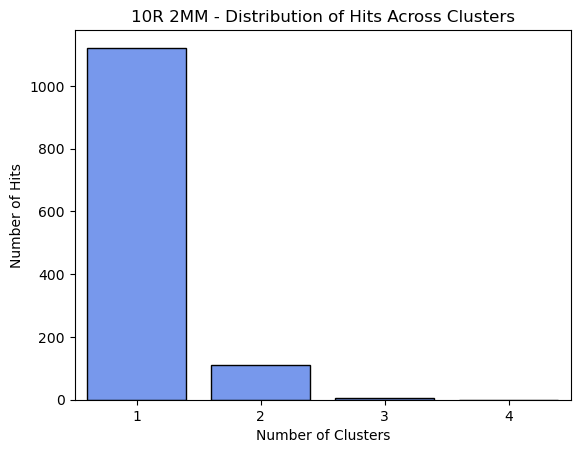

In [197]:
sns.barplot(x=list(range(1, len(clans_numbers)+2)), y=heights, edgecolor='black', color='#648FFF')   

plt.title(f'{R}R {M}MM - Distribution of Hits Across Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Number of Hits')

plt.savefig(f'/home/enno/uni/SS24/thesis/1_RegEx/1_TMP/plots/{R}R_{M}MM_{E}.png')
plt.show()

### CLANS

In [198]:
# TODO Re-do below visualization for new data structure

In [199]:
# fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# pal_5r = ['#1E88E5', '#FFC107', '#D81B60', '#9c9c9c']
# pal_7r = ['#1E88E5', '#FFC107', '#D81B60', '#000000', '#9c9c9c']

# sns.scatterplot(data=hit_df_5r, x='x', y='y', hue='cl', palette=pal_5r, s=10, ax=axes[0])
# sns.scatterplot(data=sample_5r, x='x', y='y', hue='cl', palette=pal_5r[1:2], s=100, edgecolor='black', ax=axes[0])

# sns.scatterplot(data=hit_df_7r, x='x', y='y', hue='cl', palette=pal_7r, s=10, ax=axes[1])
# sns.scatterplot(data=sample_7r, x='x', y='y', hue='cl', palette=pal_7r[0:2] + pal_7r[-1:], s=100, edgecolor='black', ax=axes[1])

# handles, labels = axes[0].get_legend_handles_labels()
# axes[0].legend(handles=handles[:4], labels=labels[:4])
# axes[0].set_title('5R')

# handles, labels = axes[1].get_legend_handles_labels()
# axes[1].legend(handles=handles[:5], labels=labels[:5])
# axes[1].set_title('7R')

# plt.show()

In [200]:
# fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# pal_5r = ['#1E88E5', '#FFC107', '#D81B60', '#9c9c9c']
# pal_7r = ['#1E88E5', '#FFC107', '#D81B60', '#000000', '#9c9c9c']

# sns.scatterplot(data=df[df.reduced_group == 'TMP'], x='x', y='y', s=15, c='#9c9c9c', ax=axes[0])
# sns.scatterplot(data=tmp_df_5r[tmp_df_5r['C'] != 'CX_norm'], x='x', y='y', edgecolor='black', ax=axes[0], s=15, hue='C')

# sns.scatterplot(data=df[df.reduced_group == 'TMP'], x='x', y='y', s=15, c='#9c9c9c', ax=axes[1])
# sns.scatterplot(data=tmp_df_7r[tmp_df_7r['C'] != 'CX_norm'], x='x', y='y', edgecolor='black', ax=axes[1], s=15, hue='C')

# handles, labels = axes[0].get_legend_handles_labels()
# axes[0].legend(handles=handles[:4], labels=labels[:4])
# axes[0].set_title('5R')

# handles, labels = axes[1].get_legend_handles_labels()
# axes[1].legend(handles=handles[:5], labels=labels[:5])
# axes[1].set_title('7R')

# plt.show()